# Import package

In [1]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer

from sklearn.cluster import KMeans
from sklearn.metrics import fowlkes_mallows_score, rand_score, adjusted_rand_score, v_measure_score, \
	silhouette_score, calinski_harabasz_score, davies_bouldin_score

from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import matplotlib
import sklearn as sk

import numpy as np
import math
from time import time

# Data Loading

We only used the dataset after feature engineering, whose input contains $561$ features.

In [2]:
def load_data(root_path, suffix) -> tuple[np.ndarray, np.ndarray]:
    X = np.loadtxt(f"{root_path}/X_{suffix}.txt")
    y = np.loadtxt(f"{root_path}/y_{suffix}.txt")
    return X, y

def load_label_name(root_path) -> dict[int, str] :
    with open(f"{root_path}/activity_labels.txt", "r") as f:
        lines = f.readlines()
        label_name = {}
        for line in lines:
            line = line.strip().split()
            label_name[int(line[0])] = line[1]
    
    return label_name

def label_binarize(y) -> np.ndarray :
    global handler
    if "handler" not in globals() or handler is None :
        handler = LabelBinarizer()
        _, y_train = load_data("./data/train", "train")
        handler.fit(y_train)
    
    return handler.transform(y)

# Visualization

Use t-SNE for dimension reduction and visualization. We implemented two functions for figure generations:

1. Show directly on $\texttt{ipynb}$
2. Save as $\texttt{png}$ files

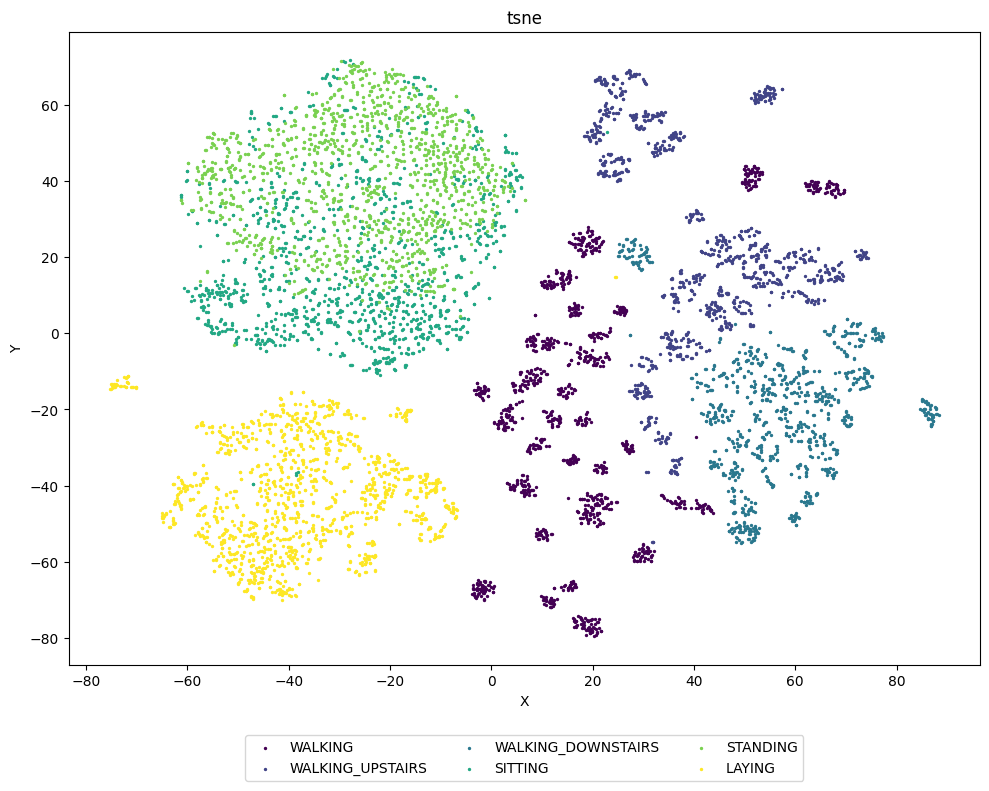

In [ ]:
def dimension_reduction(x, dim_target = 3, algorithm = "PCA") :
    if algorithm == "PCA" :
        pca = sk.decomposition.PCA(n_components=dim_target)
        x = pca.fit_transform(x)
    elif algorithm == "TSNE" :
        tsne = sk.manifold.TSNE(n_components=dim_target)
        x = tsne.fit_transform(x)

    return x

def get_label_color(label) :
    global colormap, y_min, y_max
    if "colormap" not in globals() :
        colormap = matplotlib.colormaps["viridis"]
        _, y_train = load_data("./data/train", "train")
        y_min = np.min(y_train)
        y_max = np.max(y_train)

    return colormap((label - y_min) / (y_max - y_min))

def plot(
        x = list[np.ndarray] | np.ndarray, 
        y = list[np.ndarray] | np.ndarray, 
        dim_target : int | list[int] = 3, 
        name : list[str] | str | None = None,
        label : dict[str] | None = None,
        save_path = None,
        ) :
    
    if type(x) == np.ndarray : x = [x]
    if type(y) == np.ndarray : y = [y] * len(x)
    if type(dim_target) == int : dim_target = [dim_target] * len(x)
    if type(name) == str : name = [name] * len(x)

    if len(x) != len(y) or len(x) != len(dim_target) :
        raise ValueError("x, y, dim_target, need_dimension_reduction must have the same length")
    
    nrow = 1 if len(x) <= 3 else 2
    ncol = int(math.ceil(len(x) / nrow))

    fig = plt.figure(figsize=(10, 8))

    if name is None :
        name = [f"Plot {i}" for i in range(len(x))]

    # write each plot in a different subplot
    for i in range(len(x)) :
        
        if dim_target[i] == 2 :
            ax = fig.add_subplot(nrow, ncol, i + 1)
            if label is not None :
                y_min = np.min(y[i])
                y_max = np.max(y[i])

                cmap = matplotlib.colormaps['viridis']
                colors = [cmap((i - y_min) / (y_max - y_min)) for i in range(int(y_min), int(y_max) + 1)]
                for j in range(int(y_min), int(y_max) + 1) :
                    ax.scatter(x[i][y[i] == j, 0], x[i][y[i] == j, 1], s=2, color=colors[j - int(y_min)], label=label[j])
            else :
                ax.scatter(x[i][:, 0], x[i][:, 1], c=y[i], s=2)
        elif dim_target[i] == 3 :
            ax = fig.add_subplot(nrow, ncol, i + 1, projection='3d')
            if label is not None :
                y_min = np.min(y[i])
                y_max = np.max(y[i])

                cmap = matplotlib.colormaps['viridis']
                colors = [cmap((i - y_min) / (y_max - y_min)) for i in range(int(y_min), int(y_max) + 1)]
                for j in range(int(y_min), int(y_max) + 1) :
                    ax.scatter(x[i][y[i] == j, 0], x[i][y[i] == j, 1], x[i][y[i] == j, 2], s=2, color=colors[j - int(y_min)], label=label[j])
            else :
                ax.scatter(x[i][:, 0], x[i][:, 1], x[i][:, 2], c=y[i], s=2)
            
            ax.set_zlabel("Z")

        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_title(name[i])
        if label is not None :
            ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3)
    plt.tight_layout()

    if save_path is not None :
        plt.savefig(save_path, dpi=300)
    else :
        plt.show()

if __name__ == "__main__" :
    X, y = load_data("./data/train", "train")
    X_tsne = dimension_reduction(X, 2, "TSNE")
    X_pca = dimension_reduction(X, 2, "PCA")
    plot([X_tsne], [y], dim_target=2, name="tsne", label=load_label_name("./data"))

# Clustering

Implement usage of two cluster algorithm from $\texttt{sklearn}$ : $\text{kmeans}$ and $\text{hierarchical}$.

Use the same function from Visualization part to demonstrate the result of clustering.

metric of kmeans orginal
external metric: 
	fowlkes_mallows score : 0.5544948410724351
	rand score : 0.8380895820914567
	adjusted rand score : 0.4549249500915282
	v measure score : 0.5832664512032797
internal metric: 
	silhouette score : 0.1452927728332213
	calinski harabasz score : 3103.2207607201476
	davies bouldin score : 2.172360549174361

metric of kmeans dimension reduction
external metric: 
	fowlkes_mallows score : 0.7040890465173936
	rand score : 0.8998955898459479
	adjusted rand score : 0.6438471539694107
	v measure score : 0.7272541623932225
internal metric: 
	silhouette score : 0.3925347626209259
	calinski harabasz score : 7766.68896484375
	davies bouldin score : 0.9026574785788305

metric of hierarchical orginal
external metric: 
	fowlkes_mallows score : 0.6012982642784007
	rand score : 0.8561175972001767
	adjusted rand score : 0.5128694931363761
	v measure score : 0.6524080662014535
internal metric: 
	silhouette score : 0.10883881681249784
	calinski harabasz score : 2941.2

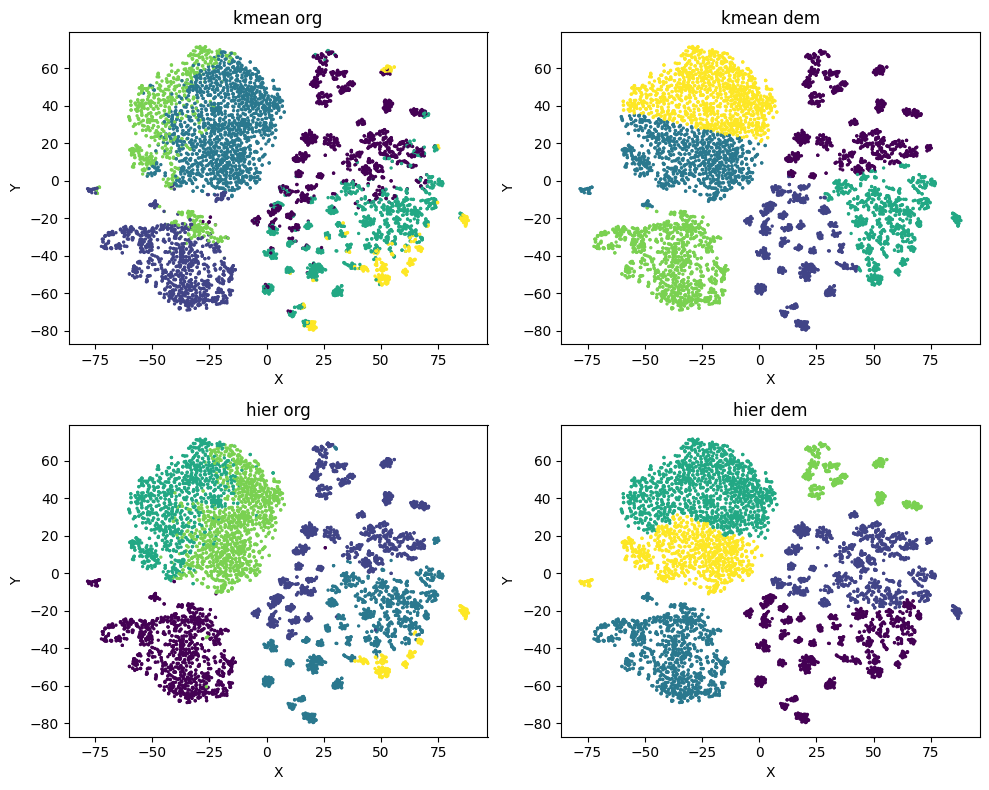

In [4]:
def kmeans(X : np.ndarray, n_clusters: int, n_init: int = 10) -> tuple :
	km = KMeans(n_clusters=n_clusters, n_init=n_init, max_iter=600)

	km.fit(X)

	return km.labels_, km.cluster_centers_

def hierarchical(X : np.ndarray, n_clusters: int) -> tuple :
	from sklearn.cluster import AgglomerativeClustering

	ag = AgglomerativeClustering(n_clusters=n_clusters)

	ag.fit(X)

	return ag.labels_, ag.children_

def metric(name : str, X : np.ndarray, y : np.ndarray, labels : np.ndarray, centers : np.ndarray) :
	print(f"metric of {name}")

	print("external metric: ")

	# fowlkes_mallows score
	print(f"\tfowlkes_mallows score : {fowlkes_mallows_score(y, labels)}")

	# rand score
	print(f"\trand score : {rand_score(y, labels)}")

	# adjusted rand score
	print(f"\tadjusted rand score : {adjusted_rand_score(y, labels)}")

	# v measure score
	print(f"\tv measure score : {v_measure_score(y, labels)}")

	print("internal metric: ")

	# silhouette score
	print(f"\tsilhouette score : {silhouette_score(X, labels)}")

	# calinski harabasz score
	print(f"\tcalinski harabasz score : {calinski_harabasz_score(X, labels)}")
	# davies bouldin score
	print(f"\tdavies bouldin score : {davies_bouldin_score(X, labels)}")

	print()



if __name__ == "__main__" :
	X, y = load_data("./data/train", "train")

	x_dem = dimension_reduction(X, 2, "TSNE")

	labels_kmeans_dem, centers_kmeans_dem = kmeans(x_dem, 6, 20)
	# cluster using the orginal data
	labels_kmeans_org, centers_kmeans_org = kmeans(X, 6, 20)

	labels_hierarchical_dem, children_hierarchical_dem = hierarchical(x_dem, 6)
	# cluster using the orginal data
	labels_hierarchical_org, children_hierarchical_org = hierarchical(X, 6)
	
	metric("kmeans orginal", X, y, labels_kmeans_org, centers_kmeans_org)
	metric("kmeans dimension reduction", x_dem, y, labels_kmeans_dem, centers_kmeans_dem)

	metric("hierarchical orginal", X, y, labels_hierarchical_org, children_hierarchical_org)
	metric("hierarchical dimension reduction", x_dem, y, labels_hierarchical_dem, children_hierarchical_dem)

	# plot the clusters
	plot(
		[x_dem, x_dem, x_dem, x_dem], 
		[labels_kmeans_org, labels_kmeans_dem, labels_hierarchical_org, labels_hierarchical_dem], 
		dim_target=2, 
		name=["kmean org", "kmean dem", "hier org", "hier dem"])

# Prediction and Model Choice

Select some simple models and ensemble models.

Then we choose logistic regression for further exploration.

metric of Logistic Regression :
time cost : 77.30 s
accuracy : 0.9528333898880217
              precision    recall  f1-score   support

         1.0       0.91      0.99      0.95       496
         2.0       0.97      0.91      0.94       471
         3.0       0.99      0.96      0.98       420
         4.0       0.95      0.89      0.92       491
         5.0       0.91      0.96      0.93       532
         6.0       0.99      1.00      0.99       537

    accuracy                           0.95      2947
   macro avg       0.96      0.95      0.95      2947
weighted avg       0.95      0.95      0.95      2947

confusion matrix :
[[492   1   3   0   0   0]
 [ 40 429   2   0   0   0]
 [  6   9 405   0   0   0]
 [  0   1   0 436  50   4]
 [  0   0   0  21 509   2]
 [  0   0   0   0   0 537]]

metric of Ridge Regression :
time cost : 77.30 s
accuracy : 0.9528333898880217
              precision    recall  f1-score   support

         1.0       0.91      0.99      0.95       496
    

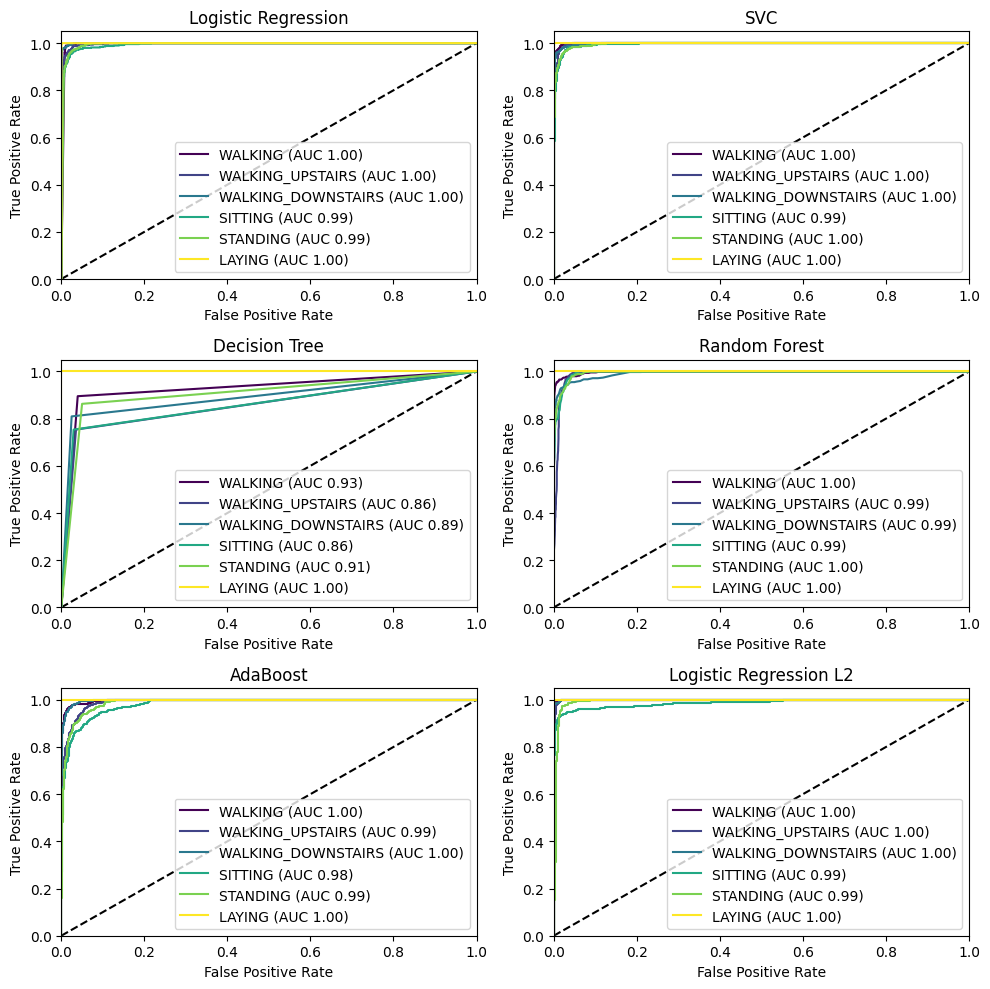

In [6]:
best_model = None
best_accuracy = 0

fig = plt.figure(figsize=(10, 10))
nrow, ncol = 3, 2
idx = 0

def evaluate(name, 
			 model : LogisticRegression | DecisionTreeClassifier | RandomForestClassifier | AdaBoostClassifier | GradientBoostingClassifier,
			 X_test, y_test, time_cost=None, eval_roc : bool = False) :
	global best_model, best_accuracy, ncol, nrow, idx
	print(f"metric of {name} :")

	y_pred = model.predict(X_test)

	print(f"time cost : {time_cost:.2f} s")
	acc = accuracy_score(y_test, y_pred)
	print(f"accuracy : {acc}")
	# update best model
	if best_model is None or best_accuracy < acc :
		best_model = model
		best_accuracy = acc

	print(classification_report(y_test, y_pred))

	print(f"confusion matrix :\n{confusion_matrix(y_test, y_pred)}")

	# draw AUC and ROC curve
	if eval_roc :
		classes_dict = load_label_name("./data")
		classes = list(classes_dict.keys())

		y_test_bin = label_binarize(y_test)
		y_score = model.predict_proba(X_test)

		fpr, tpr, roc_auc = {}, {}, {}
		for i, cls in enumerate(classes) :
			fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
			roc_auc[i] = auc(fpr[i], tpr[i])

		# draw ROC curve
		ax = fig.add_subplot(nrow, ncol, idx + 1)
		ax.plot([0, 1], [0, 1], 'k--')
		ax.set_xlim([0.0, 1.0])
		ax.set_ylim([0.0, 1.05])
		ax.set_xlabel('False Positive Rate')
		ax.set_ylabel('True Positive Rate')
		ax.set_title(name)
		for i, cls in enumerate(classes) :
			ax.plot(fpr[i], tpr[i], label=f"{classes_dict[cls]} (AUC {roc_auc[i]:.2f})", color=get_label_color(cls))
		ax.legend(loc='lower right')

		idx += 1

	print()
def pred_logistic(X_train, y_train, X_test, y_test):
	st_time = time()
	# Logistic Regression
	lr = LogisticRegression(C=1e9, max_iter=1000)
	lr.fit(X_train, y_train)
	time_cost = time() - st_time
	
	evaluate("Logistic Regression", lr, X_test, y_test, time_cost, eval_roc=True)
	
	evaluate("Ridge Regression", lr, X_test, y_test, time_cost)

def pred_dt(X_train, y_train, X_test, y_test):
	st_time = time()

	scaler = StandardScaler()
	X_train = scaler.fit_transform(X_train.data)
	X_test = scaler.transform(X_test.data)
	dt = DecisionTreeClassifier()
	dt.fit(X_train, y_train)
	time_cost = time() - st_time
	
	evaluate("Decision Tree", dt, X_test, y_test, time_cost, eval_roc=True)

def pred_rf(X_train, y_train, X_test, y_test):
	st_time = time()
	scaler = StandardScaler()
	X_train = scaler.fit_transform(X_train.data)
	X_test = scaler.transform(X_test.data)

	# Random Forest
	rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
	rf.fit(X_train, y_train)
	time_cost = time() - st_time
	
	evaluate("Random Forest", rf, X_test, y_test, time_cost, eval_roc=True)

def pred_ab(X_train, y_train, X_test, y_test):
	st_time = time()
	scaler = StandardScaler()
	X_train = scaler.fit_transform(X_train.data)
	X_test = scaler.transform(X_test.data)

	# AdaBoost
	ab = AdaBoostClassifier(n_estimators=100, estimator=DecisionTreeClassifier(max_depth=3))
	ab.fit(X_train, y_train)
	time_cost = time() - st_time	

	evaluate("AdaBoost", ab, X_test, y_test, time_cost, eval_roc=True)

def pred_svc(X_train, y_train, X_test, y_test):
	st_time = time()
	scaler = StandardScaler()
	X_train = scaler.fit_transform(X_train.data)
	X_test = scaler.transform(X_test.data)

	# SVC
	svc = SVC(probability=True)
	svc.fit(X_train, y_train)
	time_cost = time() - st_time
	
	evaluate("SVC", svc, X_test, y_test, time_cost, eval_roc=True)

# finetune the logistic regression
def finetune_logistic(X_train, y_train, X_test, y_test):
	lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)
	lr_l2 = LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000)
	lr_l2_2 = LogisticRegression(penalty='l2', solver='saga', max_iter=1000)

	st_time = time()
	lr_l1.fit(X_train, y_train)
	time_cost1 = time() - st_time
	st_time = time()
	lr_l2.fit(X_train, y_train)
	time_cost2 = time() - st_time

	st_time = time()
	lr_l2_2.fit(X_train, y_train)
	time_cost2_2 = time() - st_time

	evaluate("Logistic Regression L1", lr_l1, X_test, y_test, time_cost1, eval_roc=False)
	evaluate("Logistic Regression L2", lr_l2, X_test, y_test, time_cost2, eval_roc=True)
	evaluate("Logistic Regression L2 (saga)", lr_l2_2, X_test, y_test, time_cost2_2, eval_roc=False)

if __name__ == "__main__":
	# Load the data
	X_train, y_train = load_data("./data/train", "train")

	X_test, y_test = load_data("./data/test", "test")

	# Standardize the data
	
	# Predict using different classifiers
	pred_logistic(X_train, y_train, X_test, y_test)
	pred_svc(X_train, y_train, X_test, y_test)
	pred_dt(X_train, y_train, X_test, y_test)
	pred_rf(X_train, y_train, X_test, y_test)
	pred_ab(X_train, y_train, X_test, y_test)

	print(f"best model : {best_model}")
	print(f"best accuracy : {best_accuracy}")

	print(f"finetune logistic regression")
	finetune_logistic(X_train, y_train, X_test, y_test)

	plt.tight_layout()
	plt.show()

# Exploration

We tune the constant $C$ (the paramter for regualization) of logistic regression.

In [8]:
def logistic_l2(X_train, y_train, X_test, y_test) -> tuple[LogisticRegression, float] :
	search = GridSearchCV(
		LogisticRegression(random_state=114, penalty='l2', solver='liblinear', max_iter=1000),
		param_grid={
			'C': [11 + 0.1 * i for i in range(-10, 10)],
		},
		cv=5,
		n_jobs=-1,
		scoring='f1_macro'
	)
	
	start_time = time()
	search.fit(X_train, y_train)
	end_time = time()
	time_cost = end_time - start_time
	
	bst = search.best_estimator_
	print("Best parameters:", search.best_params_)
	evaluate("Logistic Regression", bst, X_test, y_test, time_cost, eval_roc=False)
	
	return bst, time_cost


if __name__ == "__main__":
	X_train, y_train = load_data("./data/train", "train")
	X_test, y_test = load_data("./data/test", "test")

	logistic_l2(X_train, y_train, X_test, y_test)


Best parameters: {'C': 11.5}
metric of Logistic Regression :
time cost : 165.77 s
accuracy : 0.9616559212758737
              precision    recall  f1-score   support

         1.0       0.95      1.00      0.97       496
         2.0       0.98      0.95      0.96       471
         3.0       1.00      0.97      0.98       420
         4.0       0.97      0.87      0.92       491
         5.0       0.90      0.98      0.93       532
         6.0       1.00      1.00      1.00       537

    accuracy                           0.96      2947
   macro avg       0.96      0.96      0.96      2947
weighted avg       0.96      0.96      0.96      2947

confusion matrix :
[[495   0   1   0   0   0]
 [ 23 448   0   0   0   0]
 [  4   8 408   0   0   0]
 [  0   3   0 427  60   1]
 [  1   0   0  12 519   0]
 [  0   0   0   0   0 537]]

